<a href="https://colab.research.google.com/github/hy2632/SystematicTrading/blob/main/Early_Profit_Taker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preface

In Robert Carver's book "Systematic Trading", he compared the two mindsets of trading: "Early Profit Taker" and "Early Loss Taker". The previous one is our mankind's "flawed instinction" and the latter one is believed to outperform the previous one.

This notebook implements the argument and verifies it through different examples.

Some of the parameters in the method is at your own discretion. Stocks and futures might take values to different orders of magnitude w.r.t. the "tolerance_lo", let alone the fact that everyone has his own extent of tolerance.

## Import packages and load datasets

In [ ]:
%cd /content/drive/MyDrive/SystematicTrading
import numpy as np
import pandas_datareader as pdr
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import pdb

/content/drive/MyDrive/SystematicTrading


In [ ]:
BABA = data.get_data_yahoo("BABA", "20151201", "20201201")

In [ ]:
# Download US 10 Year Treasury Futures dataset from https://www.macrotrends.net/futures/10-year-treasury
USTTEN_Future = pd.read_csv("10-year-treasury-futures.csv", skiprows=16)
USTTEN_Future.rename(columns={" value":"Adj Close"}, inplace=True)
USTTEN_Future["date"] = USTTEN_Future["date"].astype("datetime64")
USTTEN_Future_slice = USTTEN_Future[(USTTEN_Future["date"] > "2011-04-30") & (USTTEN_Future["date"] < "2012-03-01")]

USTTEN_Future_slice.set_index("date", inplace=True)
USTTEN_Future_slice

,Adj Close
date,
2011-05-02,121.2344
2011-05-03,121.4375
2011-05-04,121.6406
2011-05-05,122.0625
2011-05-06,122.2813
...,...
2012-02-23,131.2031
2012-02-24,131.1344
2012-02-27,131.5125


## Modeling 2 strategies

In [ ]:
def strategy_modeling(
        principal = 1e5,
        strategy = 'Early_Profit_Taker',
        tol_hi = 0.1,
        tol_lo = 0.05,
        position_hi = 1,
        position_lo = 0.1,
        data = BABA,
    ):
    """
        This module compare two different transaction strategies: "Early Profit Taker" and "Early Loss Taker", mentioned by Robert Carver
        in his book Systematic Trading. The previous one is mankind's instinction, while the latter one usually outperforms.
        
        ## Author
        Hua Yao (hy2632@columbia.edu)
        
        ## Reference:
        Robert Carver, Systematic Trading: A unique new method for designing trading and investing systems, Page 15.

        Parameters:
        ---------
                principal: int, your principal
                strategy: str, 'Early_Profit_Taker' / 'Early_Loss_Taker'
                tol_hi: the higher threshold of percentage change in price since last transaction
                tol_lo: the lower...
                position_hi: high position 高仓位
                position_lo: low position 低仓位
                data = BABA: pandas_datareader.data.get_data_yahoo style dataframe. Used "Adj Close" as the stock price.
    
    """



    start_date = data.index[0]
    end_date = data.index[-1]

    last_transaction = 0

    position = np.ones(len(data)) * position_hi
    num_stocks = np.ones(len(data)) * principal * position_hi / data.iloc[0]["Adj Close"]
    book_value = np.ones(len(data)) * principal


    if strategy == 'Early_Profit_Taker':
        tol_profit = tol_lo
        tol_loss = tol_hi
    else: 
        assert strategy == 'Early_Loss_Taker'
        tol_profit = tol_hi
        tol_loss = tol_lo
    
    for idx in range(1, len(data)):
        book_value[idx] = book_value[idx - 1] + num_stocks[idx] * (data.iloc[idx]["Adj Close"] / data.iloc[idx - 1]["Adj Close"] - 1)
        if position[idx - 1] == position_lo: # currently in position_lo and last transaction was selling, now buy
            if data.iloc[idx]["Adj Close"] / data.iloc[last_transaction]["Adj Close"] - 1 > tol_loss: # the price increases over the tolerance of loss after selling
                position[idx + 1:] = position_hi # buy
                num_stocks[idx + 1:] = (book_value[idx] * position_hi) / data.iloc[idx]["Adj Close"] # num_stocks decided at buying, high position
                last_transaction = idx # record
            else:
                continue
        else: # currently in position_hi and last transaction was buying
            if (data.iloc[idx]["Adj Close"] / data.iloc[last_transaction]["Adj Close"] - 1 > tol_profit) | \
                (data.iloc[idx]["Adj Close"] / data.iloc[last_transaction]["Adj Close"] - 1 < - tol_loss): # the price increases over the tolerance of profit or decreases over the tolerance of loss after buying
                position[idx + 1:] = position_lo # sell out to position_lo
                num_stocks[idx + 1:] = (book_value[idx] * position_lo) / data.iloc[idx]["Adj Close"] # num_stocks decided at selling, low position
                last_transaction = idx
            else:
                continue
            
    return position, num_stocks, book_value-principal



## Evaluate the performance

In [ ]:
def plot_strategy_comparison(
    principal = 1e5,
    tol_hi = 0.3,
    tol_lo = 0.1,
    position_hi = 1,
    position_lo = 0.1,
    data = BABA,
):

    position, num_stocks, gain = strategy_modeling(
                                            principal,
                                            'Early_Profit_Taker',
                                            tol_hi,
                                            tol_lo,
                                            position_hi,
                                            position_lo,
                                            data,
                                        )
    position_, num_stocks_, gain_ = strategy_modeling(
                                            principal,
                                            'Early_Loss_Taker',
                                            tol_hi,
                                            tol_lo,
                                            position_hi,
                                            position_lo,
                                            data,
                                        )

    # gridspec_kw: https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
    fig,ax = plt.subplots(3, 1, sharex=True, figsize=(14,12), gridspec_kw={'height_ratios': [3, 2, 2]})
    ax[0].plot(data.index, data["Adj Close"])
    ax[0].set_ylabel("Price")
    ax[1].plot(data.index, position)
    ax[1].plot(data.index, position_)
    ax[1].set_ylim(0, 1)
    ax[1].legend(["Early_Profit_Taker", "Early_Loss_Taker"])
    ax[1].set_ylabel("Position")
    ax[2].plot(data.index, gain)
    ax[2].plot(data.index, gain_)
    ax[2].legend(["Early_Profit_Taker", "Early_Loss_Taker"])
    ax[2].set_ylabel("Profits")

    plt.show()

### Example: The US Ten year treasury future (2011.05 - 2012.03)

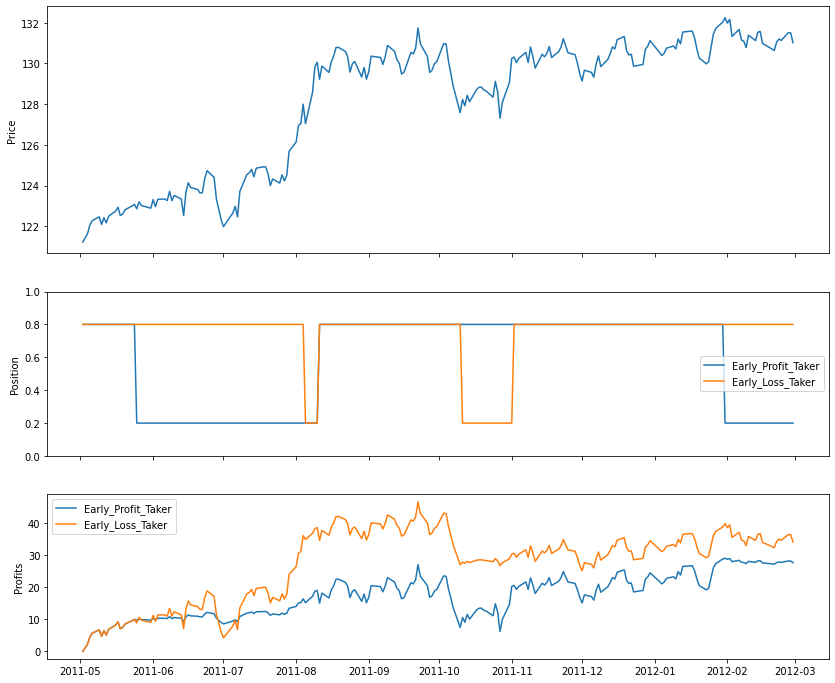

In [ ]:
plot_strategy_comparison(
    principal=1e5,
    tol_hi=0.055,
    tol_lo=0.015,
    position_hi=0.8,
    position_lo = 0.2,    
    data=USTTEN_Future_slice,
)

### Example: BABA

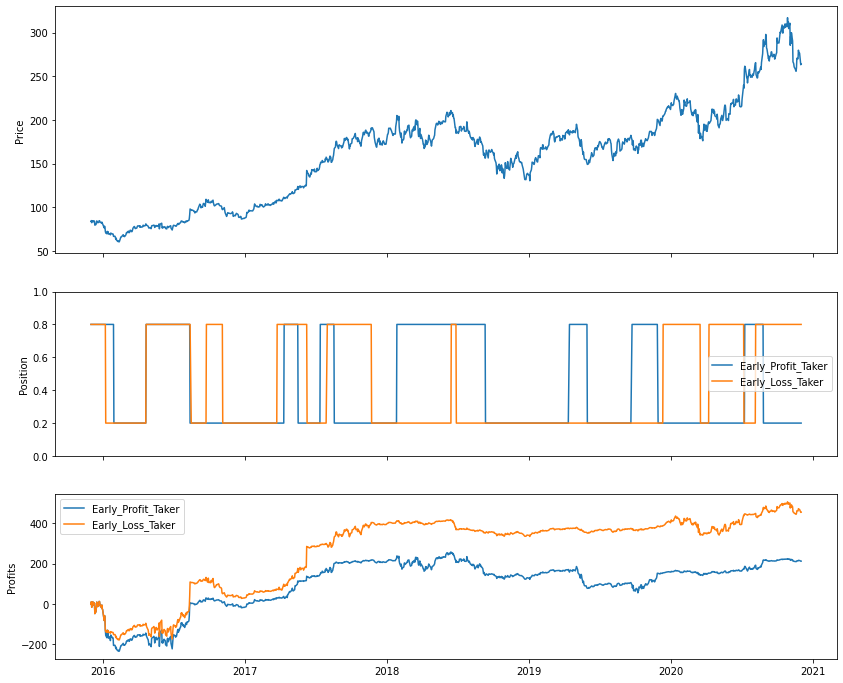

In [ ]:
plot_strategy_comparison(
    principal=1e5,
    tol_hi=0.2,
    tol_lo=0.1,
    position_hi=0.8,
    position_lo = 0.2,    
    data=BABA,
)

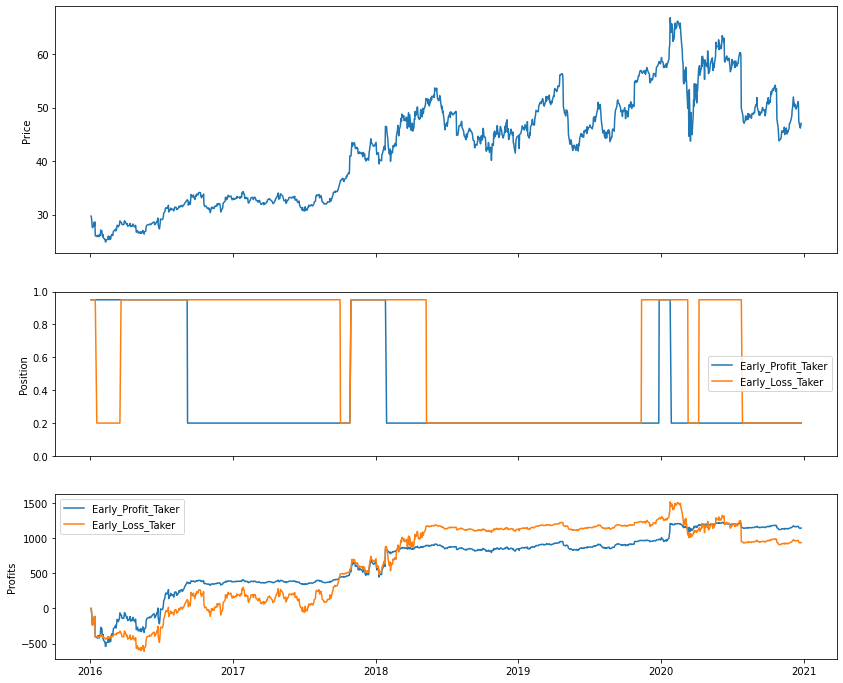

In [ ]:
plot_strategy_comparison(
    principal=1e5,
    tol_hi=0.25,
    tol_lo=0.1,
    position_hi=0.95,
    position_lo = 0.2,    
    data=data.get_data_yahoo("INTC", "20160101", "20201224"),
)

## Comment

The values of `tol_hi` and `tol_lo` as well as the ratio between them, are hard to be determined, and collectively influences the payoff. The conditions where the argument holds remain unclear.